<a href="https://colab.research.google.com/github/teator/FinEng/blob/main/MLiF/gw2_WQU_MLiF_GroupWork_sub2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---   ---   ---   ---   ---   ---   ---
## WorldQuant University :-: (19/11) MScFE 650 Machine Learning in Finance (C18-S4)
## Group work Assignment  :-:  Timezone Group 2-A  :-: Submission 2

Tea Toradze

December 2019
---   ---   ---   ---   ---   ---   ---

In [ ]:
# Upload files to temporary working environment
# (This is Google Colab specific. This is done differently in other python environments)
from google.colab import files
uploaded = files.upload()



Saving dollar_bars.csv to dollar_bars.csv
Saving tick_bars.csv to tick_bars.csv
Saving volume_bars.csv to volume_bars.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

!pip install talib-binary
import talib

%matplotlib inline
plt.rcParams['figure.figsize'] = [13, 9]



In [ ]:
# Load data
tick_bars= pd.read_csv('tick_bars.csv', index_col='date')
volume_bars= pd.read_csv('volume_bars.csv', index_col='date')
dollar_bars= pd.read_csv('dollar_bars.csv', index_col='date')



In [ ]:
# Choose test data (uncomment line with relevant database)

# data = tick_bars
# data = volume_bars
data = dollar_bars


# time = data.loc[:,'date_time']
close = data.loc[:,'close']

data



,open,high,low,close,volume,vwap
date,,,,,,
09/01/2013 18:18:59,1640.25,1642.00,1639.00,1641.25,21722,1640.667273
09/01/2013 21:42:07,1641.25,1643.50,1639.75,1640.75,21706,1641.830116
09/02/2013 02:05:25,1640.75,1644.50,1640.50,1644.50,21652,1643.149905
09/02/2013 03:01:56,1644.50,1646.00,1642.75,1645.00,21709,1644.556854
09/02/2013 04:32:44,1645.00,1647.25,1644.25,1645.50,21646,1646.012254
...,...,...,...,...,...,...
09/20/2013 15:03:48.526,1702.00,1702.25,1701.25,1701.50,21013,1701.706693
09/20/2013 15:07:25.697,1701.50,1703.00,1701.25,1702.50,20930,1702.346608
09/20/2013 15:13:47.874,1702.50,1703.25,1702.00,1703.00,20922,1702.831230



**Indicators**

In [ ]:
# Indicator functions

# Standard deviation
def sd(df, n):
    df['STD_' + str(n)] = df.close.rolling(n, min_periods=n).std()

# Moving average (simple)
def ma(df, n):
    df['MA_' + str(n)] = df.close.rolling(n, min_periods=n).mean()

# Exponential Moving Average
def ema(df, n):
    df['EMA_' + str(n)] = df.close.ewm(span=n, min_periods=n).mean()

# Momentum
def mom(df, n):
    df['MOM_' + str(n)] = df.close.diff(n)

# RSI
def rsi(df, n):
    gain = (df.close-df.close.shift(1)).fillna(0)

    def rsiCalc(p):
        avgGain = p[p>0].sum()/n
        avgLoss = -p[p<0].sum()/n
        rs = avgGain/avgLoss
        return 100 - 100/(1+rs)

    df['RSI_' + str(n)] = gain.rolling(n).apply(rsiCalc, raw=False)



In [ ]:
# Assembling indicators

def add_tech_indicator(df, lags, fun):
    for lag in lags:
        fun(df, lag)
    return df

lags = [5, 20, 100, 500]
indicators = [sd, ma, ema, mom, rsi]
data = data.copy()

for f in indicators:
    add_tech_indicator(data, lags, f)

data.tail()



,open,high,low,close,volume,vwap,STD_5,STD_20,STD_100,STD_500,MA_5,MA_20,MA_100,MA_500,EMA_5,EMA_20,EMA_100,EMA_500,MOM_5,MOM_20,MOM_100,MOM_500,RSI_5,RSI_20,RSI_100,RSI_500
date,,,,,,,,,,,,,,,,,,,,,,,,,,
09/20/2013 15:03:48.526,1702.00,1702.25,1701.25,1701.50,21013,1701.706693,0.530330,1.412526,5.143862,14.041612,1702.25,1703.6625,1711.3450,1700.3850,1702.207487,1703.689817,1709.644956,1701.316102,-1.25,-4.00,-14.50,22.50,22.222222,32.608696,40.993789,52.616279
09/20/2013 15:07:25.697,1701.50,1703.00,1701.25,1702.50,20930,1702.346608,0.541987,1.365638,5.203759,14.012900,1702.30,1703.5125,1711.2175,1700.4295,1702.304991,1703.576501,1709.503472,1701.320909,0.25,-3.00,-12.75,22.25,54.545455,38.000000,42.105263,52.588714
09/20/2013 15:13:47.874,1702.50,1703.25,1702.00,1703.00,20922,1702.831230,0.602080,1.236706,5.253774,13.984871,1702.35,1703.3625,1711.0975,1700.4745,1702.536661,1703.521596,1709.374690,1701.327726,0.25,-3.00,-12.00,22.50,54.545455,38.000000,42.592593,52.616279
09/20/2013 16:01:52.808,1703.00,1704.75,1702.00,1704.75,20938,1703.125609,1.250000,1.051002,5.283501,13.956760,1702.75,1703.2750,1711.0050,1700.5235,1703.274441,1703.638587,1709.283112,1701.341620,2.00,-1.75,-9.25,24.50,72.222222,43.636364,44.342508,52.838934
09/20/2013 16:14:59.251,1704.75,1704.75,1703.50,1703.75,2858,1704.222271,1.232376,0.920794,5.320901,13.925657,1703.10,1703.1875,1710.8975,1700.5720,1703.432960,1703.649197,1709.173546,1701.351397,1.75,-1.75,-10.75,24.25,68.421053,43.636364,43.465046,52.808338


In [ ]:
# Adding EMA crossover signals

def add_ema_crossover_signals(df, fast, slow):
    uname = "up_cross_"+fast+"_"+slow
    dname = "down_cross_"+fast+"_"+slow
    df[uname] = df[dname] = 0
    df.loc[(df[fast]>df[slow])&(df[fast].shift(1)<=df[slow].shift(1)), uname] = 1
    df.loc[(df[fast]<df[slow])&(df[fast].shift(1)>=df[slow].shift(1)), dname] = 1
    return df


data = add_ema_crossover_signals(data, "EMA_20", "EMA_500")
data.tail()



,open,high,low,close,volume,vwap,STD_5,STD_20,STD_100,STD_500,MA_5,MA_20,MA_100,MA_500,EMA_5,EMA_20,EMA_100,EMA_500,MOM_5,MOM_20,MOM_100,MOM_500,RSI_5,RSI_20,RSI_100,RSI_500,up_cross_EMA_10_EMA_250,down_cross_EMA_10_EMA_250,up_cross_EMA_20_EMA_500,down_cross_EMA_20_EMA_500
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
09/20/2013 15:03:48.526,1702.00,1702.25,1701.25,1701.50,21013,1701.706693,0.530330,1.412526,5.143862,14.041612,1702.25,1703.6625,1711.3450,1700.3850,1702.207487,1703.689817,1709.644956,1701.316102,-1.25,-4.00,-14.50,22.50,22.222222,32.608696,40.993789,52.616279,0,0,0,0
09/20/2013 15:07:25.697,1701.50,1703.00,1701.25,1702.50,20930,1702.346608,0.541987,1.365638,5.203759,14.012900,1702.30,1703.5125,1711.2175,1700.4295,1702.304991,1703.576501,1709.503472,1701.320909,0.25,-3.00,-12.75,22.25,54.545455,38.000000,42.105263,52.588714,0,0,0,0
09/20/2013 15:13:47.874,1702.50,1703.25,1702.00,1703.00,20922,1702.831230,0.602080,1.236706,5.253774,13.984871,1702.35,1703.3625,1711.0975,1700.4745,1702.536661,1703.521596,1709.374690,1701.327726,0.25,-3.00,-12.00,22.50,54.545455,38.000000,42.592593,52.616279,0,0,0,0
09/20/2013 16:01:52.808,1703.00,1704.75,1702.00,1704.75,20938,1703.125609,1.250000,1.051002,5.283501,13.956760,1702.75,1703.2750,1711.0050,1700.5235,1703.274441,1703.638587,1709.283112,1701.341620,2.00,-1.75,-9.25,24.50,72.222222,43.636364,44.342508,52.838934,0,0,0,0
09/20/2013 16:14:59.251,1704.75,1704.75,1703.50,1703.75,2858,1704.222271,1.232376,0.920794,5.320901,13.925657,1703.10,1703.1875,1710.8975,1700.5720,1703.432960,1703.649197,1709.173546,1701.351397,1.75,-1.75,-10.75,24.25,68.421053,43.636364,43.465046,52.808338,0,0,0,0


In [ ]:
# Remove redundant data
data.dropna(inplace=True)
features = StandardScaler().fit_transform(data)



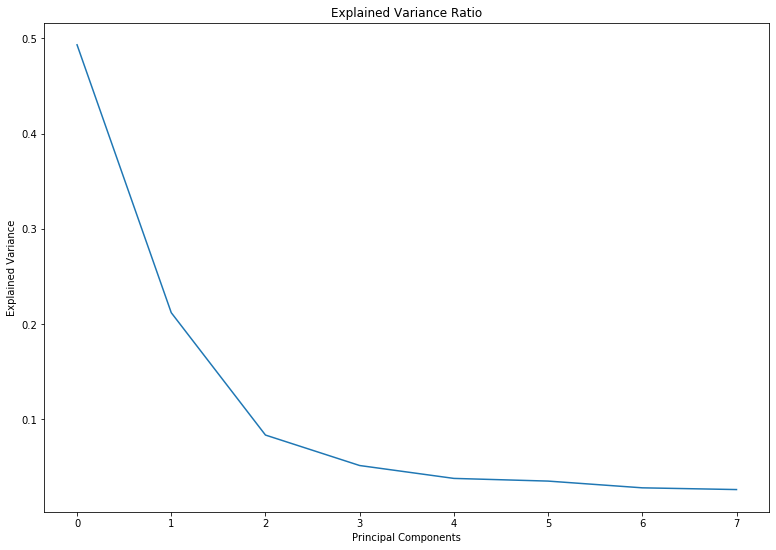

In [ ]:
# extract principal components covering 95% of variation
pca = PCA(0.95)
principal_components = pca.fit_transform(features)
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio')
plt.show()

---
**Some Visuals**

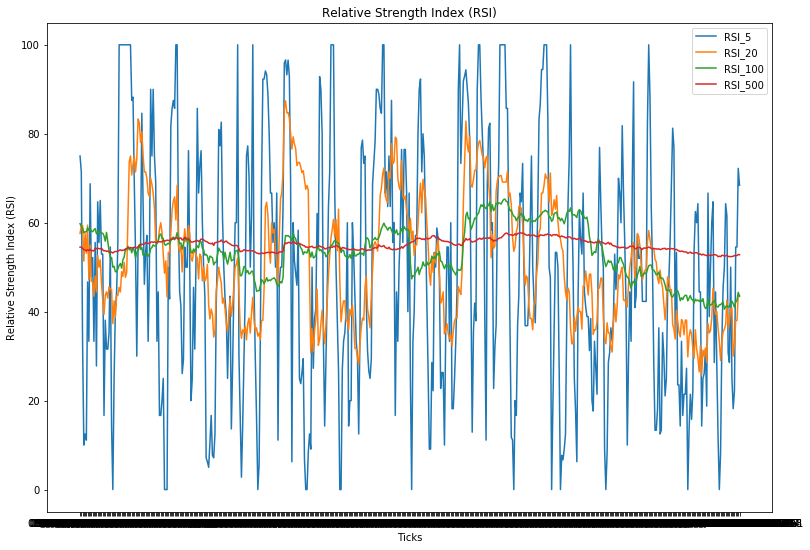

In [ ]:
# Plot RSI
plt.plot(data['RSI_5'])
plt.plot(data['RSI_20'])
plt.plot(data['RSI_100'])
plt.plot(data['RSI_500'])
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Ticks')
plt.ylabel('Relative Strength Index (RSI)')
plt.legend(['RSI_5', 'RSI_20', 'RSI_100', 'RSI_500'])
plt.show()



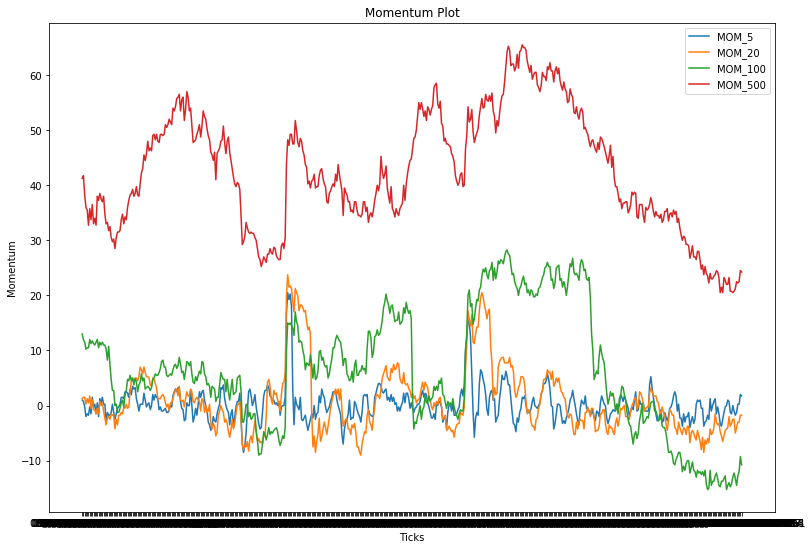

In [ ]:
# Plot momentums
plt.plot(data['MOM_5'])
plt.plot(data['MOM_20'])
plt.plot(data['MOM_100'])
plt.plot(data['MOM_500'])
plt.title('Momentum Plot')
plt.xlabel('Ticks')
plt.ylabel('Momentum')
plt.legend(['MOM_5', 'MOM_20', 'MOM_100', 'MOM_500'])
plt.show()



---
**Moving average crossover**

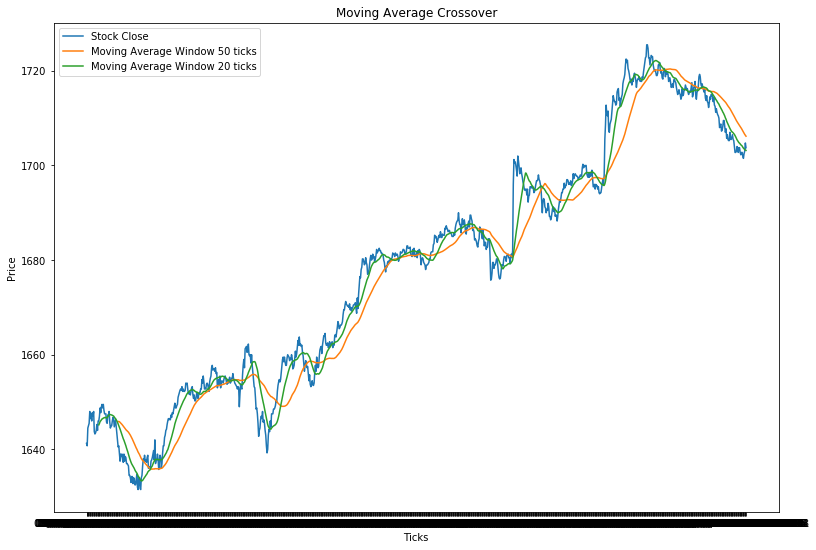

In [ ]:
# Moving average crossover
long_window = 50
short_window = 20

long_rolling = close.rolling(long_window).mean()
short_rolling = close.rolling(short_window).mean()

# plot
plt.plot(close)
plt.plot(long_rolling)
plt.plot(short_rolling)
plt.title('Moving Average Crossover')
plt.xlabel('Ticks')
plt.ylabel('Price')
plt.legend(['Stock Close', 'Moving Average Window 50 ticks', 'Moving Average Window 20 ticks'])
plt.show()



### Using 'talib' package

In [ ]:
# Universal function for modelling and assembling various features

def feature_assemble(data):

    """
    slowk, slowd == slow stochastic,
    willr == William's R,
    rsi == RSI,
    mom == momentum,
    macd, macdsignal, macdhist == MACD,
    upperband, middleband, lowerband == Bollinger Bands,
    kama == kaufmann adaptive moving average,
    sar == Parabolic SAR,
    tema == triple exponential moving average,
    doji_star == doji star,
    hammer == Hammer,
    inv_hammer == Inverted Hammer,
    shooting_star == shooting star,
    stddev == standard deviation,
    tsf == time series forecast,
    atr == ATR
    """

    slowk, slowd = talib.STOCH(data.high, data.low, data.close) # slow stochastic

    willr = talib.WILLR(data.high, data.low, data.close) # William's R

    rsi = talib.RSI(data.close) # RSI

    mom = talib.MOM(data.close) # momentum

    macd, macdsignal, macdhist = talib.MACD(data.close) # MACD

    upperband, middleband, lowerband = talib.BBANDS(data.close) # Bollinger Bands

    kama = talib.KAMA(data.close) # kaufmann adaptive moving average

    sar = talib.SAR(data.high, data.low) # Parabolic SAR

    tema = talib.TEMA(data.close) # triple exponential moving average

    doji_star = talib.CDLDOJISTAR(data.open, data.high, data.low, data.close) # doji star

    hammer = talib.CDLHAMMER(data.open, data.high, data.low, data.close) # Hammer

    inv_hammer = talib.CDLINVERTEDHAMMER(data.open, data.high, data.low, data.close) # Inverted Hammer

    shooting_star = talib.CDLSHOOTINGSTAR(data.open, data.high, data.low, data.close) # shooting star

    stddev = talib.STDDEV(data.close, timeperiod=20) # standard deviation

    tsf = talib.TSF(data.close) # time series forecast

    atr = talib.ATR(data.high, data.low, data.close) # ATR


    # Assembling features dictionary
    features = {'slowk':slowk, 'slowd':slowd,
                'willr':willr, 'rsi':rsi,
                'mom':mom,
                'macd':macd, 'macdsignal':macdsignal, 'macdhist':macdhist,
                'upperband':upperband, 'middleband':middleband, 'lowerband':lowerband,
                'kama':kama,
                'sar':sar,
                'tema':tema,
                'doji_star':doji_star,
                'hammer':hammer,
                'inv_hammer':inv_hammer,
                'shooting_star':shooting_star,
                'stddev':stddev,
                'tsf':tsf,
                'atr':atr}


    # Append features to the data
    for feature in features:
        data[feature] = features[feature]

    # return data
    return data




In [ ]:
# Applying universal function to out data
feature_assemble(dollar_bars)



,open,high,low,close,volume,vwap,slowk,slowd,willr,rsi,mom,macd,macdsignal,macdhist,upperband,middleband,lowerband,kama,sar,tema,doji_star,hammer,inv_hammer,shooting_star,stddev,tsf,atr
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
09/01/2013 18:18:59,1640.25,1642.00,1639.00,1641.25,21722,1640.667273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN,NaN,NaN
09/01/2013 21:42:07,1641.25,1643.50,1639.75,1640.75,21706,1641.830116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1639.000000,NaN,0,0,0,0,NaN,NaN,NaN
09/02/2013 02:05:25,1640.75,1644.50,1640.50,1644.50,21652,1643.149905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1639.090000,NaN,0,0,0,0,NaN,NaN,NaN
09/02/2013 03:01:56,1644.50,1646.00,1642.75,1645.00,21709,1644.556854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1639.306400,NaN,0,0,0,0,NaN,NaN,NaN
09/02/2013 04:32:44,1645.00,1647.25,1644.25,1645.50,21646,1646.012254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1647.382462,1643.40,1639.417538,NaN,1639.708016,NaN,0,0,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
09/20/2013 15:03:48.526,1702.00,1702.25,1701.25,1701.50,21013,1701.706693,26.725589,30.120651,-92.857143,32.552585,-2.50,-1.415354,-1.457888,0.042534,1703.198683,1702.25,1701.301317,1704.908048,1703.399179,1701.553535,0,0,0,0,1.376760,1702.184066,1.507369
09/20/2013 15:07:25.697,1701.50,1703.00,1701.25,1702.50,20930,1702.346608,32.407407,30.934343,-64.285714,39.758227,-1.25,-1.342232,-1.434757,0.092524,1703.269536,1702.30,1701.330464,1704.787539,1703.250000,1701.535204,0,0,0,0,1.331059,1702.046703,1.524700
09/20/2013 15:13:47.874,1702.50,1703.25,1702.00,1703.00,20922,1702.831230,54.166667,37.766554,-50.000000,43.035169,0.25,-1.229762,-1.393758,0.163996,1703.427033,1702.35,1701.272967,1704.730130,1701.250000,1701.621962,0,0,0,0,1.205392,1702.060440,1.505079
